# Description of the Data - Capstone Project - The Battle of Neighborhood

### User is Planning to open a restaurant  

New York City's demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. New York City was home to nearly 8.5 million people in 2014, accounting for over 40% of the population of New York State and a slightly lower percentage of the New York metropolitan area, home to approximately 23.6 million. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States.

Throughout its history, New York City has been a major point of entry for immigrants; the term "melting pot" was coined to describe densely populated immigrant neighborhoods on the Lower East Side. As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world. English remains the most widely spoken language, although there are areas in the outer boroughs in which up to 25% of people speak English as an alternate language, and/or have limited or no English language fluency. English is least spoken in neighborhoods such as Flushing, Sunset Park, and Corona.

With it's diverse culture , comes diverse food items. There are many resturants in New york City, each beloning to different categories like Chinese , Indian , French etc.

So as part of this project , we will list and visualize all major parts of New York City that has great indian resturants.

___

### Data

For this project we need the following data :

* New York City data that contains list Boroughs,Neighborhoods along with their latitude and longitude.
     * Data source : https://cocl.us/new_york_dataset
     * Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city.
     
* Indian resturants in each neighborhood of new york city.
    * Data source : Fousquare API
    * Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only indian resturants.
* GeoSpace data:
    * Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
    * Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.

___

### Approach

1. Collect the new york city data from https://cocl.us/new_york_dataset
2. Using FourSquare API we will find all venues for each neighborhood.
3. Filter out all venues that are Indian Resturants.
4. Find rating , tips and like count for each Indian Resturants using FourSquare API.
5. Using rating for each resturant , we will sort that data.
6. Visualize the Ranking of neighborhoods using folium library(python)

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
!pip install geocoder
!pip install folium
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

### Define Foursqure API

In [20]:
CLIENT_ID = '3PYY4CVU2N25XJE22RJ2N3U4WPQCVDEV3Q112SV0JRACHASA'
CLIENT_SECRET = 'GQAPMMQYMBTAYGZQSIC4NRQ4N100QM1WEOMHWKFNDGU5FBNY'
VERSION= '20180605'
radius=1000
LIMIT=100

In [4]:
def get_venues(lat,lng):
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [5]:
def get_venue_details(venue_id):
        
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [6]:
def get_new_york_data():
    url='https://firebasestorage.googleapis.com/v0/b/trancy777.appspot.com/o/nyu_2451_34572-geojson.json?alt=media&token=a1c16bd2-f207-4ea3-8228-945a3eae1bb7'
    resp=requests.get(url).json()
    features=resp['features']
    
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

#### call the above funtion to get the new york city data.

In [7]:
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
new_york_data.shape

(306, 4)

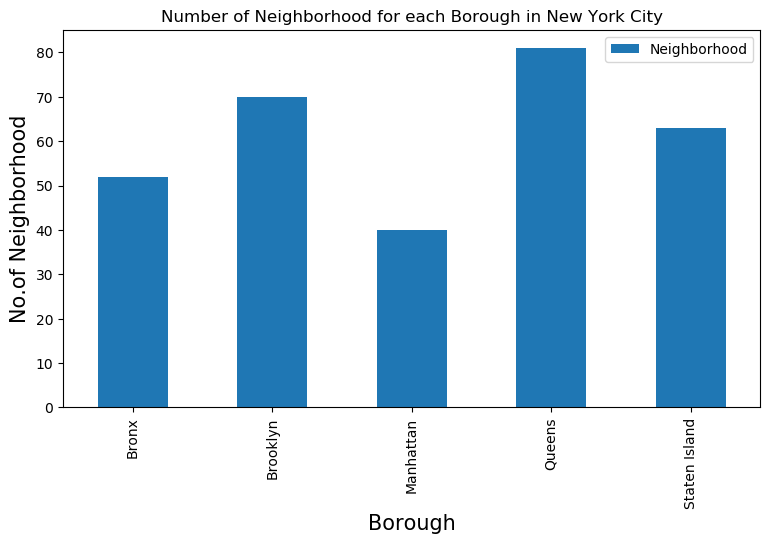

In [9]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Neighborhood for each Borough in New York City')

plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Neighborhood', fontsize=15)

new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.legend()
plt.show()

#### We see that Queens has highest number of neighborhoods

#### Now we will collect Indian resturants for each Neighborhood

In [10]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

In [11]:
indian_rest_ny.shape

(156, 4)

In [12]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Williamsbridge,570c3a3fcd10eecd0d0434cd,Agra Grill
2,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird


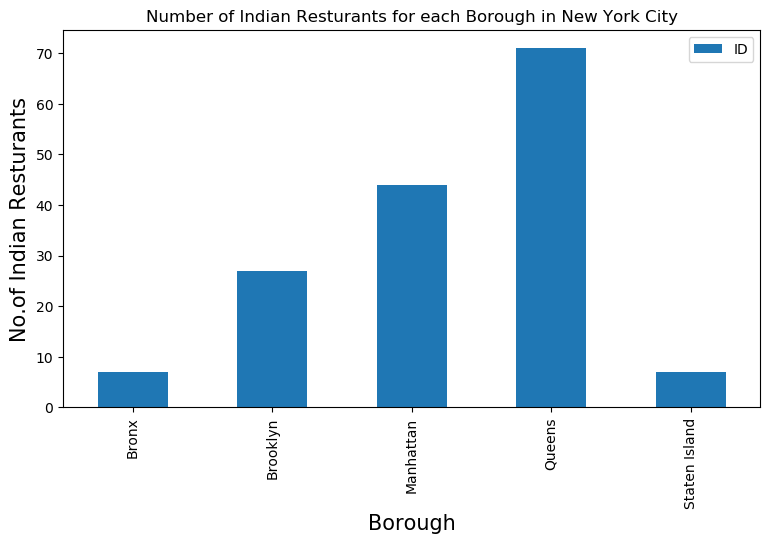

In [13]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Indian Resturants for each Borough in New York City')

plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Indian Resturants', fontsize=15)

indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
plt.legend()
plt.show()

<b> We see that Queens has the largest number of indian resturants </b>

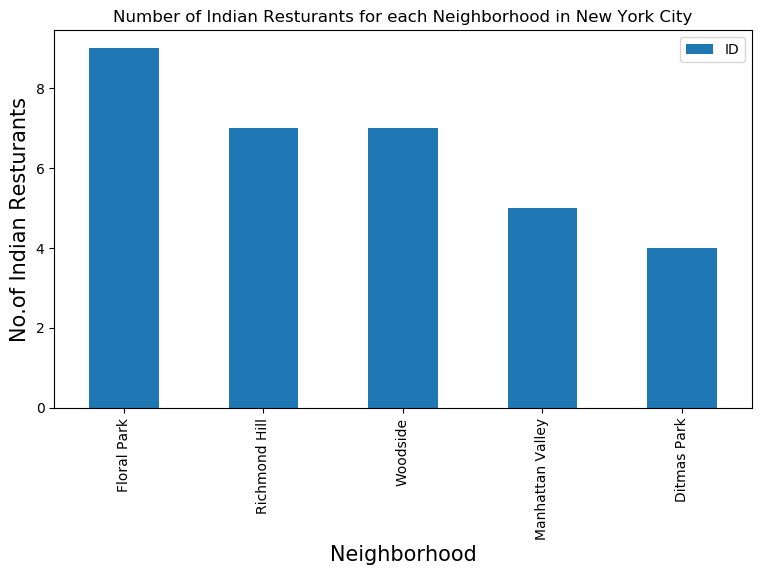

In [14]:
plt.figure(figsize=(9,5),dpi=100)
plt.title('Number of Indian Resturants for each Neighborhood in New York City')

plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No.of Indian Resturants', fontsize=15)

indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
plt.legend()
plt.show()

In [15]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
104,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
105,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
106,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
107,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
108,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
109,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
110,Queens,Floral Park,4c953a7672dd224bd8d1a191,Real Usha Sweets & Snacks Inc.
111,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
112,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


In [16]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park'].shape

(9, 4)

### So Floral Park in Queens has the highest number of Indian Resturants with a total count of 9.

<b> Now we will get the ranking of each resturant for further analysis.</b>

In [48]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1

for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        ## print('No data available for id=',ID)
        id,name,likes,rating,tips=[0]*5
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
    if count == 50:
        break

In [49]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.8,11
1,Bronx,Williamsbridge,0,0,0,0.0,0
2,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,5.9,2
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.4,9
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.9,3


In [50]:
indian_rest_stats_ny.shape

(49, 7)

In [51]:
indian_rest_ny.shape

(156, 4)

<b> So we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required </b>

In [52]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

<b> Lets verify the data from saved csv file </b>

In [53]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')
indian_rest_stats_ny_csv.shape

(49, 7)

In [54]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.8,11
1,Bronx,Williamsbridge,0,0,0,0.0,0
2,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,5.9,2
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.4,9
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.9,3


In [55]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 7 columns):
Borough         49 non-null object
Neighborhood    49 non-null object
ID              49 non-null object
Name            49 non-null object
Likes           49 non-null object
Rating          49 non-null float64
Tips            49 non-null object
dtypes: float64(1), object(6)
memory usage: 2.8+ KB


In [56]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')

In [57]:
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [58]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 7 columns):
Borough         49 non-null object
Neighborhood    49 non-null object
ID              49 non-null object
Name            49 non-null object
Likes           49 non-null float64
Rating          49 non-null float64
Tips            49 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.8+ KB


In [59]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                836
Rating                               8.7
Tips                                 259
Name: 41, dtype: object

In [60]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                588
Rating                               9.1
Tips                                 146
Name: 44, dtype: object

In [61]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                836
Rating                               8.7
Tips                                 259
Name: 41, dtype: object

In [62]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [63]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
27,Tribeca,9.10
12,Greenwich Village,9.00
31,West Village,8.95
9,Fort Greene,8.80
4,Clinton Hill,8.80
17,Midtown,8.70
18,Murray Hill,8.70
25,South Side,8.50
19,North Side,8.50
34,Yorkville,8.50


<b> Above are the top neighborhoods with top average rating of Indian resturants </b>

In [64]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [65]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.200000
1,Brooklyn,7.395455
0,Bronx,5.483333


<b> Similarly these are the average rating of Indian Resturants for each Borough </b>

### Visual

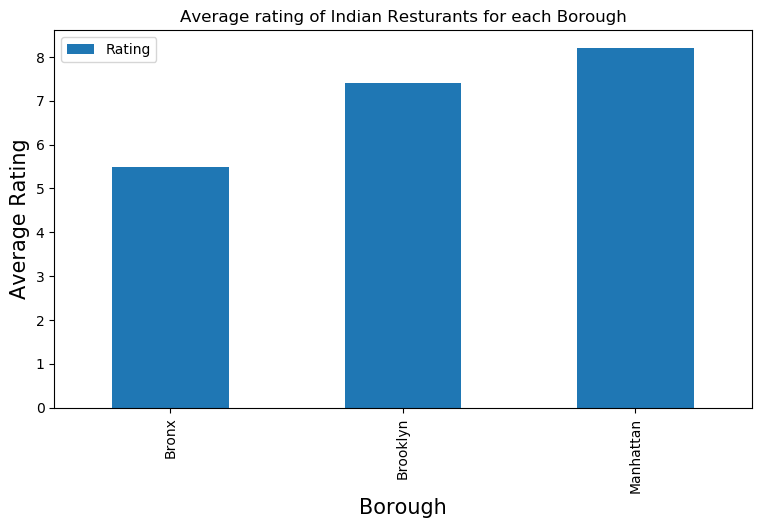

In [66]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Indian Resturants for each Borough')

plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')

plt.legend()
plt.show()

<b> We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map </b>

In [67]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
12,Greenwich Village,9.0
27,Tribeca,9.1


In [68]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [69]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Greenwich Village,40.726933,-73.999914,9.0
1,Manhattan,Tribeca,40.721522,-74.010683,9.1


In [70]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [71]:
incidents = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

<b> Lets add a new field to dataframe for labeling purpose </b>

In [73]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [74]:
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

<b> Now that we have visualized the Neighborhoods.
Lets Visualize Boroughs based on average Rating </b>

### Conclusion

* Astoria(Queens), Blissville(Queens), Civic Center(Manhattan) are some of the best neighborhoods for indian cuisine.
* Manhattan have potential Indian Resturant Market/
* Staten Island ranks last in average rating of Indian Resturants.
* Manhattan is the best place to stay if you prefer Indian Cuisine.

## Limitations

* The ranking is purely on basis of rating of resturants
* The accuracy of data depends purely depends on the data provided by FourSquare